<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Handwritten Digit Classification using Decision Tree**

***Introduction:***

This project aims to classify handwritten digits using a Decision Tree Classifier. The dataset consists of images where each image is represented as pixel values. The classification is done based on extracted features and decision tree splitting criteria.

In [ ]:
import numpy as np
import gdown
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [ ]:
# file import from derive
train_file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
test_file_id = "1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy"

train_url = f"https://drive.google.com/uc?id={train_file_id}"
test_url = f"https://drive.google.com/uc?id={test_file_id}"


# downloading file
train_output = "train_dataset.csv"
test_output = "test_dataset.csv"

gdown.download(train_url, train_output, quiet=False)
gdown.download(test_url, test_output, quiet=False)


# dataframe formation
train_df = pd.read_csv(train_output, header=None)
test_df = pd.read_csv(test_output, header=None)


print(train_df.head())
#----------------------------------------------------------------------

# making y = label(1st column) and x = row (other column).

#for train dataset
y_train = train_df.iloc[:, 0].values  # Labels
X_train = train_df.iloc[:, 1:].values  # Features (pixel values)

#for test dataset
y_test = test_df.iloc[:, 0].values  # Labels
X_test = test_df.iloc[:, 1:].values  # Features (pixel values)

# normalize pixel values (0-255 → 0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# shape of train and test
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

#----------------------------------------------------------------------

# displaying some images.|
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")

plt.show()

**Decision Tree Classifier Implementation**

Entropy Calculation:
Formula Used:

entropy(y) function calculates entropy for a given set of labels.
Helps measure impurity in a set before and after splitting.

**Finding the Best Split:**
Iterates over features and thresholds to determine the best split.
Uses Information Gain formula:
Chooses the feature and threshold maximizing information gain.

In [ ]:
# Define entropy function
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

# Find best split
def best_split(X, y):
    best_feature, best_threshold, best_gain = None, None, 0
    for feature in range(X.shape[1]):
        values = np.unique(X[:, feature])
        for threshold in values:
            left_mask = X[:, feature] < threshold
            right_mask = ~left_mask
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue
            left_entropy = entropy(y[left_mask])
            right_entropy = entropy(y[right_mask])
            gain = entropy(y) - (np.sum(left_mask) / len(y)) * left_entropy - (np.sum(right_mask) / len(y)) * right_entropy
            if gain > best_gain:
                best_feature, best_threshold, best_gain = feature, threshold, gain
    return best_feature, best_threshold


**Building the Decision Tree:**
The Node class defines each decision node with:
Feature index,
Threshold value,
Left and right child nodes,
Leaf node value (final prediction).
The recursive build_tree() function constructs the tree up to max_depth=10.

In [ ]:
# Define Decision Tree Node class
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# Build decision tree
def build_tree(X, y, depth=0, max_depth=10):
    if len(np.unique(y)) == 1:
        return Node(value=np.unique(y)[0])
    if depth >= max_depth:
        return Node(value=np.bincount(y).argmax())
    feature, threshold = best_split(X, y)
    if feature is None:
        return Node(value=np.bincount(y).argmax())
    left_mask = X[:, feature] < threshold
    right_mask = ~left_mask
    left_subtree = build_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
    right_subtree = build_tree(X[right_mask], y[right_mask], depth + 1, max_depth)
    return Node(feature=feature, threshold=threshold, left=left_subtree, right=right_subtree)


**Making Predictions:**

Predict() function traverses the tree for each test sample.
Starts at root node and follows the left or right branch based on the threshold until a leaf node is reached.

In [ ]:
# Predict function
def predict(tree, X):
    predictions = []
    for sample in X:
        node = tree
        while node.left or node.right:
            if sample[node.feature] < node.threshold:
                node = node.left
            else:
                node = node.right
        predictions.append(node.value)
    return np.array(predictions)

# Train Decision Tree
tree = build_tree(X_train, y_train, max_depth=10)

# Make Predictions
y_pred = predict(tree, X_test)


**Evaluation Metrics**

**Accuracy:**
Measures overall correct classifications.

**Formula**: Corrected predication/Total predication

Computed using accuracy_score().
Precision, Recall, F1-Score:

**Precision** = True Positives / (True Positives + False Positives)

**Recall** = True Positives / (True Positives + False Negatives)

**F1-Score** = Harmonic Mean of Precision & Recall

Evaluated using classification_report().

**Confusion Matrix:**

Displays actual vs predicted class distribution.

Plotted using seaborn.heatmap().

In [ ]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted') * 100
    recall = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100

    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")

evaluate_model(y_test, y_pred)

Precision: 86.30%
Recall: 86.33%
F1 Score: 86.30%


In [ ]:
# overall accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"\nAccuracy: {accuracy:.4f}")


Accuracy: 0.8632



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1185
           1       0.94      0.95      0.95      1348
           2       0.84      0.86      0.85      1192
           3       0.82      0.83      0.82      1226
           4       0.83      0.85      0.84      1168
           5       0.82      0.77      0.79      1084
           6       0.91      0.88      0.89      1184
           7       0.89      0.90      0.90      1253
           8       0.82      0.80      0.81      1170
           9       0.82      0.82      0.82      1190

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



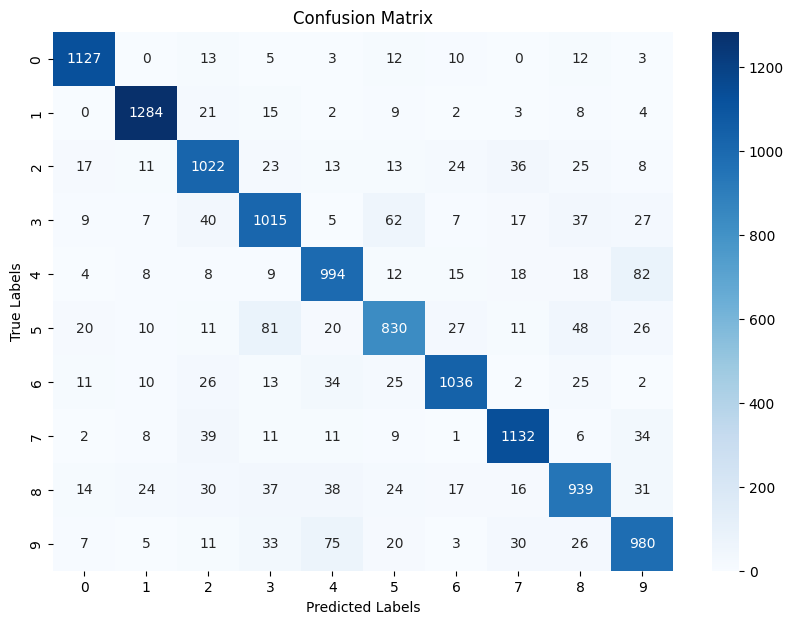

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


***ROC Curve (One-vs-Rest for Multi-class Classification)***

**ROC Curve** plots True Positive Rate (TPR) vs False Positive Rate (FPR).

**AUC** (Area Under Curve) values are computed for each digit class

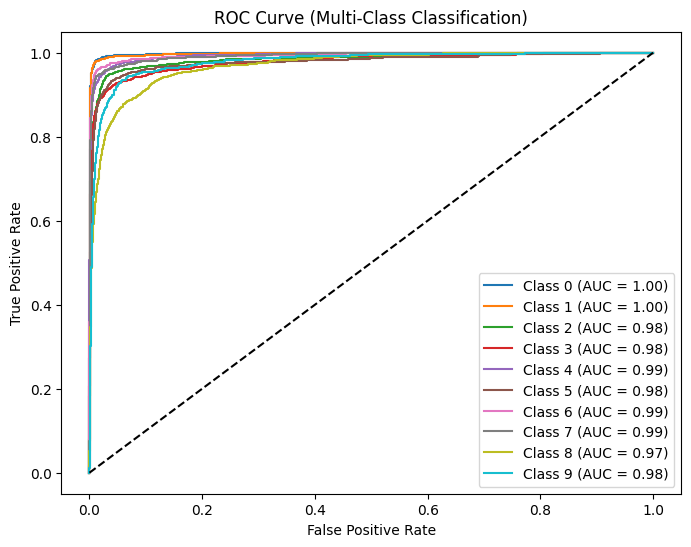

In [ ]:
# Convert labels to one-hot encoding for multi-class ROC
y_train_bin = label_binarize(y_train, classes=np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_train_bin.shape[1]

# Train a One-vs-Rest Logistic Regression Model
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, y_train_bin)

# Get probability predictions
y_score = clf.predict_proba(X_test)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc:.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multi-Class Classification)")
plt.legend()
plt.show()


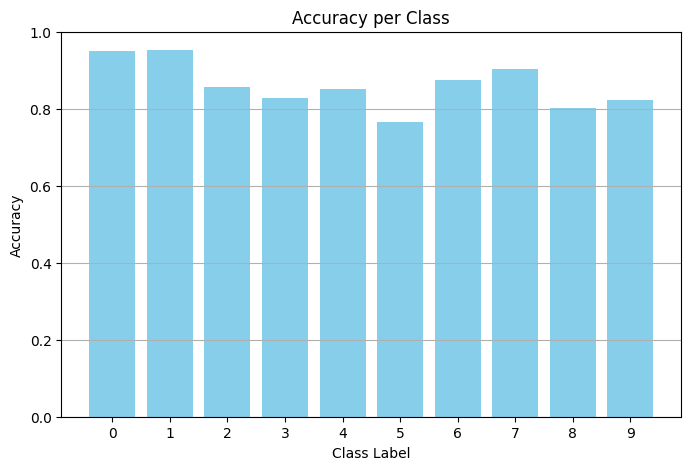

In [ ]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute Accuracy per Class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_accuracy = np.nan_to_num(class_accuracy)  # Replace NaN with 0 for empty classes

# Plot Accuracy per Class
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_accuracy)), class_accuracy, color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy per Class")
plt.xticks(range(len(class_accuracy)))
plt.grid(axis="y")
plt.show()

**Decision Tree Depth Optimization**

A separate section tests different tree depths (1-30) using DecisionTreeClassifier() from sklearn.

**Overfitting Check:**

**1.**Training accuracy is high for deep trees but testing accuracy may drop.

**2.**Optimal depth is selected where the test accuracy stabilizes.

**3.**A graph is plotted to visualize accuracy vs depth.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score

# Load handwritten digits dataset (MNIST-like)
digits = load_digits()
X, y = digits.data, digits.target  # Features and labels

# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Trying different depths
depths = range(1, 30)  # Testing depths from 1 to 20
train_acc = []
test_acc = []

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)  # Create tree with given depth
    clf.fit(X_train, y_train)  # Train the model

    # Predict on train and test sets
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)

    # Calculate accuracies
    train_acc.append(accuracy_score(y_train, train_pred))
    test_acc.append(accuracy_score(y_test, test_pred))

# Plot graph
plt.figure(figsize=(8, 5))
plt.plot(depths, train_acc, label="Training Accuracy", marker='o')
plt.plot(depths, test_acc, label="Testing Accuracy", marker='s', linestyle='dashed')
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Depth vs Accuracy")
plt.legend()
plt.grid(True)
plt.show()

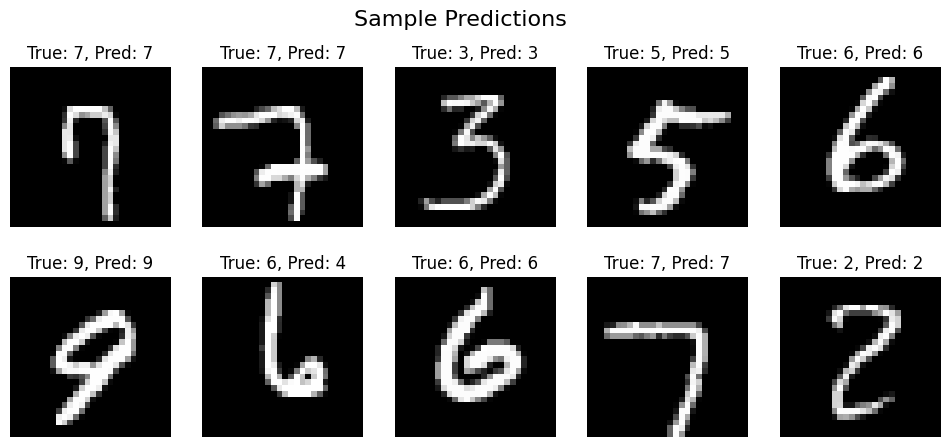

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Sample Predictions", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred[i]}")
    ax.axis("off")

plt.show()
